In [1]:
import torch.nn as nn
import torch
import torchvision.transforms as transforms
import torchvision
import time
import numpy as np
from sklearn.metrics import confusion_matrix
import pandas as pd
import os
import torchvision.models as models
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,f1_score,ConfusionMatrixDisplay

In [2]:
img_size = (299, 299)
data = []
labels = []

In [3]:
def set_device():
    device = "mps" if torch.backends.mps.is_available() else "cpu"
    return device

In [4]:
device=set_device()

In [5]:
# Loop over each class folder in the dataset folder
for class_folder in os.listdir('dataset_2_class/train/'):
    class_folder_path = os.path.join('dataset_2_class/train', class_folder)
    if os.path.isdir(class_folder_path):
        # Loop over each image file in the class folder
        for file_name in os.listdir(class_folder_path):
            if file_name.endswith('.JPG'):
                # Load the image and resize it to the desired size
                img = cv2.imread(os.path.join(class_folder_path, file_name))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
                img= cv2.resize(img,img_size)

                # Add the image data and label to the lists
                data.append(img)
                labels.append(class_folder)

In [6]:
data=np.array(data)
labels=np.array(labels)
data_t=torch.from_numpy(data)

In [7]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
classes=np.unique(labels)
labels=label_encoder.fit_transform(labels)
labels_t=torch.from_numpy(labels)


In [8]:
print(data_t.shape)
print(labels_t.shape)

torch.Size([13783, 299, 299, 3])
torch.Size([13783])


In [9]:
print(classes)

['healthy' 'unhealthy']


In [10]:
def get_model():
    model = models.inception_v3(pretrained=False)
    for param in model.parameters():
        param.requires_grad = False #Freezing all the layers and changing only the below layers
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
    model.fc = nn.Sequential(nn.Flatten(),
                            nn.Linear(2048,128),
                            nn.ReLU(),
                            nn.Linear(128,2))
    model.aux_logits = False
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-3,momentum=0.9)
    return model.to(device), loss_fn, optimizer

In [11]:
@torch.no_grad()
def accuracy(images, labels, model):
    model.eval()
    prediction = model(images)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == labels
    return is_correct.cpu().numpy().tolist()

In [12]:
def evaluate_model(model,test_loader):
    model.eval()
    predicted_correct =0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images,labels = data
            images = images.to(device)
            labels = labels.to(device)
            total+=labels.size(0)
            outputs = model(images)
            _,predicted = torch.max(outputs,1)
            predicted_correct += (predicted == labels).sum().item()
    epoch_accuracy = 100.0* predicted_correct/total
    print("Testing Data: Epoch Accuracy: %.3f"%(epoch_accuracy))
    return epoch_accuracy

In [13]:
model, loss_fn, optimizer = get_model()

/Users/bhanuprakash/miniforge3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/bhanuprakash/miniforge3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/Users/bhanuprakash/miniforge3/lib/python3.10/site-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


In [14]:
from torch.utils.data import Dataset, DataLoader

In [15]:
data_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [16]:
# Define the PyTorch dataset and dataloader
class ImageDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __getitem__(self, index):
        img = self.data[index]
        label = self.labels[index]
        img = torch.tensor(img, dtype=torch.float32)
        img = img.permute(2, 0, 1)  # change the image from HxWxC to CxHxW
        img = data_transforms(img)
        return img, label

    def __len__(self):
        return len(self.data)

In [17]:
def get_mean_std(loader):
    mean = 0.
    std = 0.
    total_images_count = 0
    for images,_ in loader:
        images_count_in_batch = images.size(0)
#         print(images.shape)
        images =images.view(images_count_in_batch,images.size(1),-1)
        mean+=images.mean(2).sum(0)
        std+=images.std(2).sum(0)
        total_images_count+=images_count_in_batch
    mean /= total_images_count
    std /= total_images_count
    return mean,std

In [18]:
def transform(dataset):
    data_transform = transforms.Compose([transforms.Resize((299,299)),transforms.ToTensor()])
    data_set=torchvision.datasets.ImageFolder(root=dataset,transform=data_transform)
    data_loader=torch.utils.data.DataLoader(dataset=data_set,batch_size=32,shuffle=True)
    mean,std=get_mean_std(data_loader)
    data_transform = transforms.Compose([
        transforms.Resize((299,299)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(torch.Tensor(mean),torch.Tensor(std))
    ])
    data_set=torchvision.datasets.ImageFolder(root=dataset,transform=data_transform)
    data_loader=torch.utils.data.DataLoader(dataset=data_set,batch_size=32,shuffle=True,drop_last=False,num_workers=0)
    return data_loader

In [19]:
test_dataset='dataset_2_class/test/'
test_loader=transform(test_dataset)

In [20]:
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=0.0001)

In [21]:
from sklearn.model_selection import StratifiedKFold

In [22]:
kfold = StratifiedKFold(n_splits=7, shuffle=True, random_state=42)

In [23]:
from statistics import mean
fold_train_accuracy=[]
fold_train_loss=[]
fold_val_accuracy=[]
fold_val_loss=[]
fold_test_accuracy=[]
fold_precision_score=[]
fold_recall_score=[]
fold_f1_score=[]

Fold: 1 
Epoch: 1 


/var/folders/wd/g8mvvv392p11yf16rzs6k9mr0000gn/T/ipykernel_1890/3107720099.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img, dtype=torch.float32)


Training Data: Epoch Loss: 0.602, Epoch Accuracy: 67.318, Validation Loss: 0.556,Validation accuracy: 67.699
Epoch: 2 
Training Data: Epoch Loss: 0.522, Epoch Accuracy: 73.667, Validation Loss: 0.451,Validation accuracy: 78.822
Epoch: 3 
Training Data: Epoch Loss: 0.465, Epoch Accuracy: 78.551, Validation Loss: 0.393,Validation accuracy: 85.526
Epoch: 4 
Training Data: Epoch Loss: 0.447, Epoch Accuracy: 79.778, Validation Loss: 0.382,Validation accuracy: 82.986
Epoch: 5 
Training Data: Epoch Loss: 0.438, Epoch Accuracy: 80.091, Validation Loss: 0.393,Validation accuracy: 82.529
Epoch: 6 
Training Data: Epoch Loss: 0.432, Epoch Accuracy: 80.201, Validation Loss: 0.368,Validation accuracy: 85.373
Epoch: 7 
Training Data: Epoch Loss: 0.425, Epoch Accuracy: 80.752, Validation Loss: 0.369,Validation accuracy: 85.830
Epoch: 8 
Training Data: Epoch Loss: 0.425, Epoch Accuracy: 80.472, Validation Loss: 0.363,Validation accuracy: 84.408
Epoch: 9 
Training Data: Epoch Loss: 0.426, Epoch Accuracy

Training Data: Epoch Loss: 0.379, Epoch Accuracy: 83.054, Validation Loss: 0.311,Validation accuracy: 87.252
Epoch: 71 
Training Data: Epoch Loss: 0.379, Epoch Accuracy: 83.570, Validation Loss: 0.304,Validation accuracy: 87.760
Epoch: 72 
Training Data: Epoch Loss: 0.374, Epoch Accuracy: 83.410, Validation Loss: 0.313,Validation accuracy: 87.405
Epoch: 73 
Training Data: Epoch Loss: 0.374, Epoch Accuracy: 83.494, Validation Loss: 0.305,Validation accuracy: 88.725
Epoch: 74 
Training Data: Epoch Loss: 0.377, Epoch Accuracy: 83.469, Validation Loss: 0.306,Validation accuracy: 88.268
Epoch: 75 
Training Data: Epoch Loss: 0.375, Epoch Accuracy: 83.486, Validation Loss: 0.295,Validation accuracy: 88.878
Epoch: 76 
Training Data: Epoch Loss: 0.379, Epoch Accuracy: 83.181, Validation Loss: 0.299,Validation accuracy: 89.335
Epoch: 77 
Training Data: Epoch Loss: 0.379, Epoch Accuracy: 83.283, Validation Loss: 0.307,Validation accuracy: 88.116
Epoch: 78 
Training Data: Epoch Loss: 0.372, Epoch 

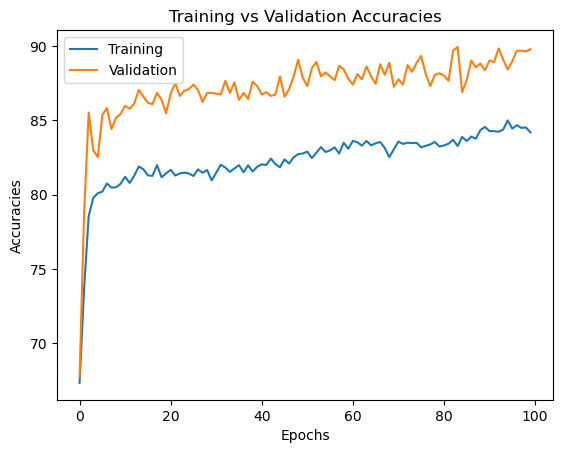

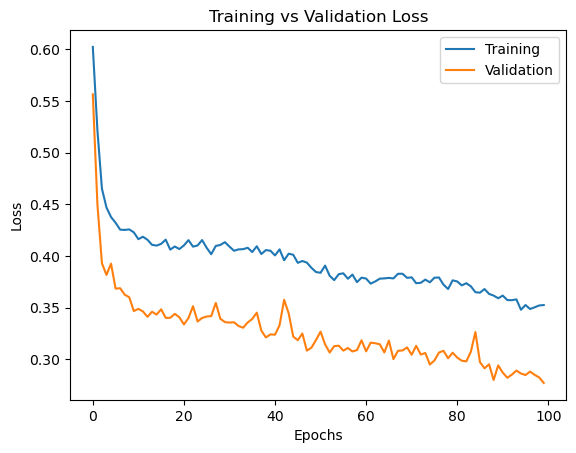

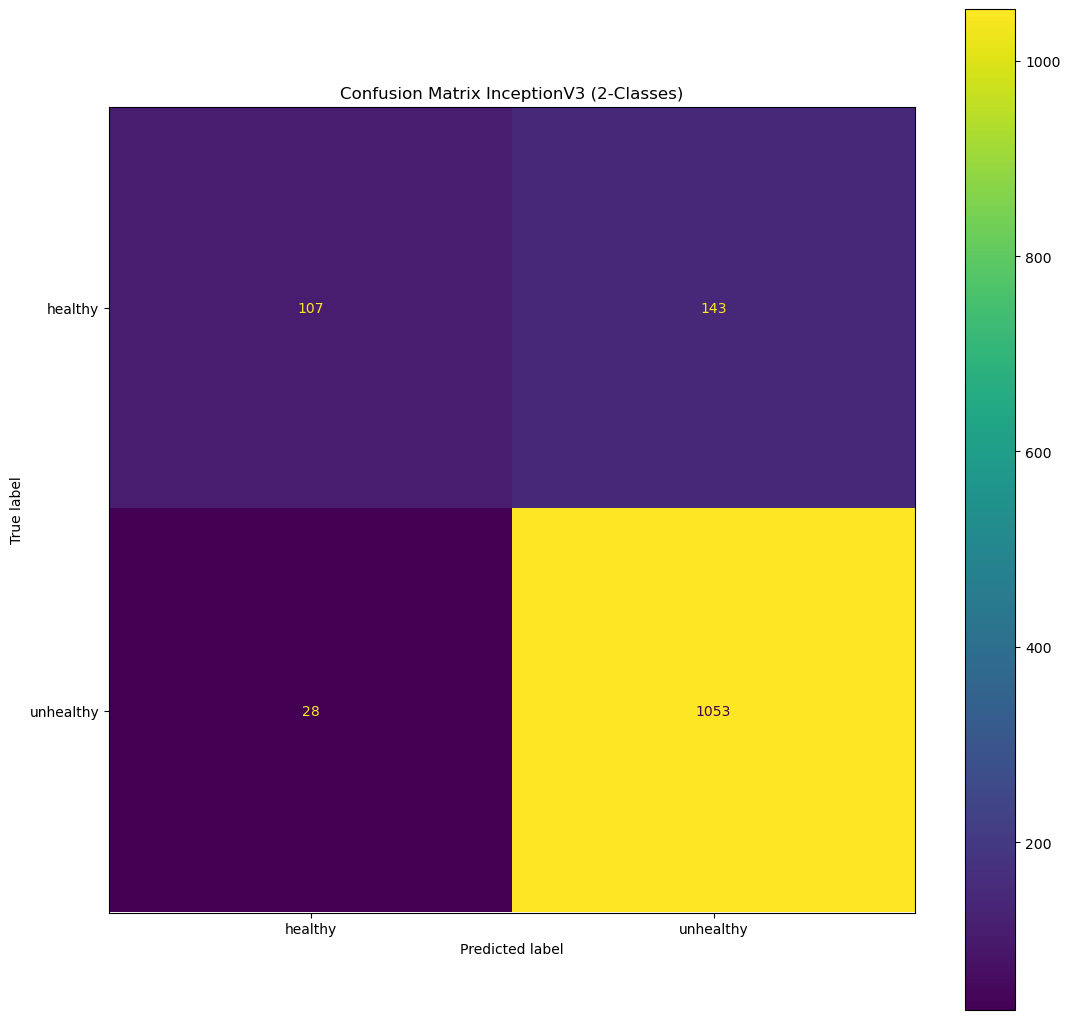

Precision Macro:0.84
Precision Micro:0.87
Recall Macro:0.70
Recall Micro:0.87
F1-Score Macro:0.74
F1-Score Micro:0.87
Fold: 2 
Epoch: 1 


/var/folders/wd/g8mvvv392p11yf16rzs6k9mr0000gn/T/ipykernel_1890/3107720099.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img, dtype=torch.float32)


Training Data: Epoch Loss: 0.352, Epoch Accuracy: 84.865, Validation Loss: 0.286,Validation accuracy: 90.046
Epoch: 2 
Training Data: Epoch Loss: 0.348, Epoch Accuracy: 84.942, Validation Loss: 0.274,Validation accuracy: 89.589
Epoch: 3 
Training Data: Epoch Loss: 0.352, Epoch Accuracy: 84.679, Validation Loss: 0.273,Validation accuracy: 88.827
Epoch: 4 
Training Data: Epoch Loss: 0.353, Epoch Accuracy: 84.696, Validation Loss: 0.276,Validation accuracy: 89.538
Epoch: 5 
Training Data: Epoch Loss: 0.360, Epoch Accuracy: 84.366, Validation Loss: 0.278,Validation accuracy: 88.928
Epoch: 6 
Training Data: Epoch Loss: 0.352, Epoch Accuracy: 84.857, Validation Loss: 0.272,Validation accuracy: 89.944
Epoch: 7 
Training Data: Epoch Loss: 0.358, Epoch Accuracy: 84.451, Validation Loss: 0.277,Validation accuracy: 89.487
Epoch: 8 
Training Data: Epoch Loss: 0.349, Epoch Accuracy: 84.992, Validation Loss: 0.284,Validation accuracy: 89.436
Epoch: 9 
Training Data: Epoch Loss: 0.345, Epoch Accuracy

Training Data: Epoch Loss: 0.327, Epoch Accuracy: 86.059, Validation Loss: 0.251,Validation accuracy: 90.249
Epoch: 71 
Training Data: Epoch Loss: 0.326, Epoch Accuracy: 86.169, Validation Loss: 0.251,Validation accuracy: 90.503
Epoch: 72 
Training Data: Epoch Loss: 0.324, Epoch Accuracy: 86.144, Validation Loss: 0.251,Validation accuracy: 90.452
Epoch: 73 
Training Data: Epoch Loss: 0.326, Epoch Accuracy: 85.940, Validation Loss: 0.249,Validation accuracy: 90.249
Epoch: 74 
Training Data: Epoch Loss: 0.322, Epoch Accuracy: 86.093, Validation Loss: 0.249,Validation accuracy: 90.554
Epoch: 75 
Training Data: Epoch Loss: 0.322, Epoch Accuracy: 86.567, Validation Loss: 0.247,Validation accuracy: 90.858
Epoch: 76 
Training Data: Epoch Loss: 0.327, Epoch Accuracy: 85.653, Validation Loss: 0.239,Validation accuracy: 90.909
Epoch: 77 
Training Data: Epoch Loss: 0.320, Epoch Accuracy: 86.397, Validation Loss: 0.245,Validation accuracy: 90.808
Epoch: 78 
Training Data: Epoch Loss: 0.324, Epoch 

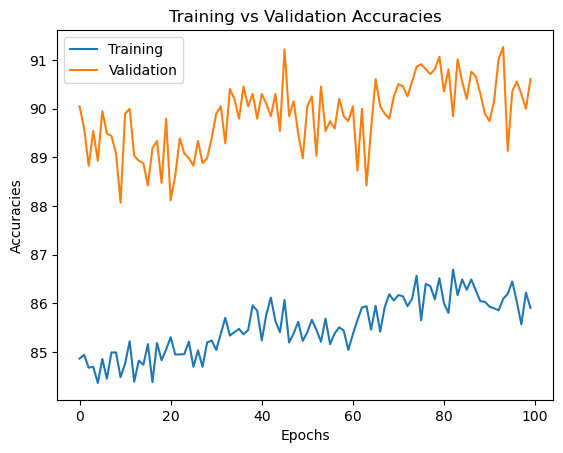

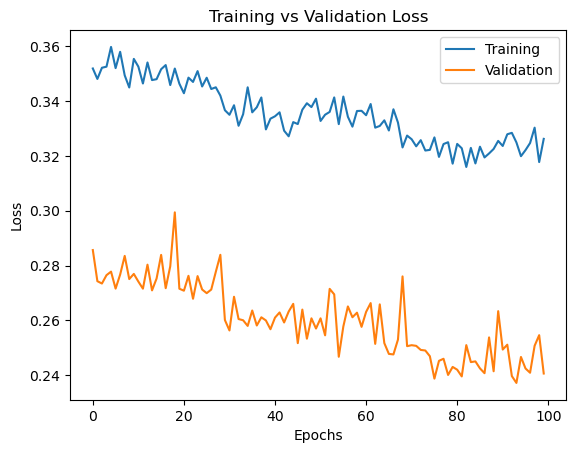

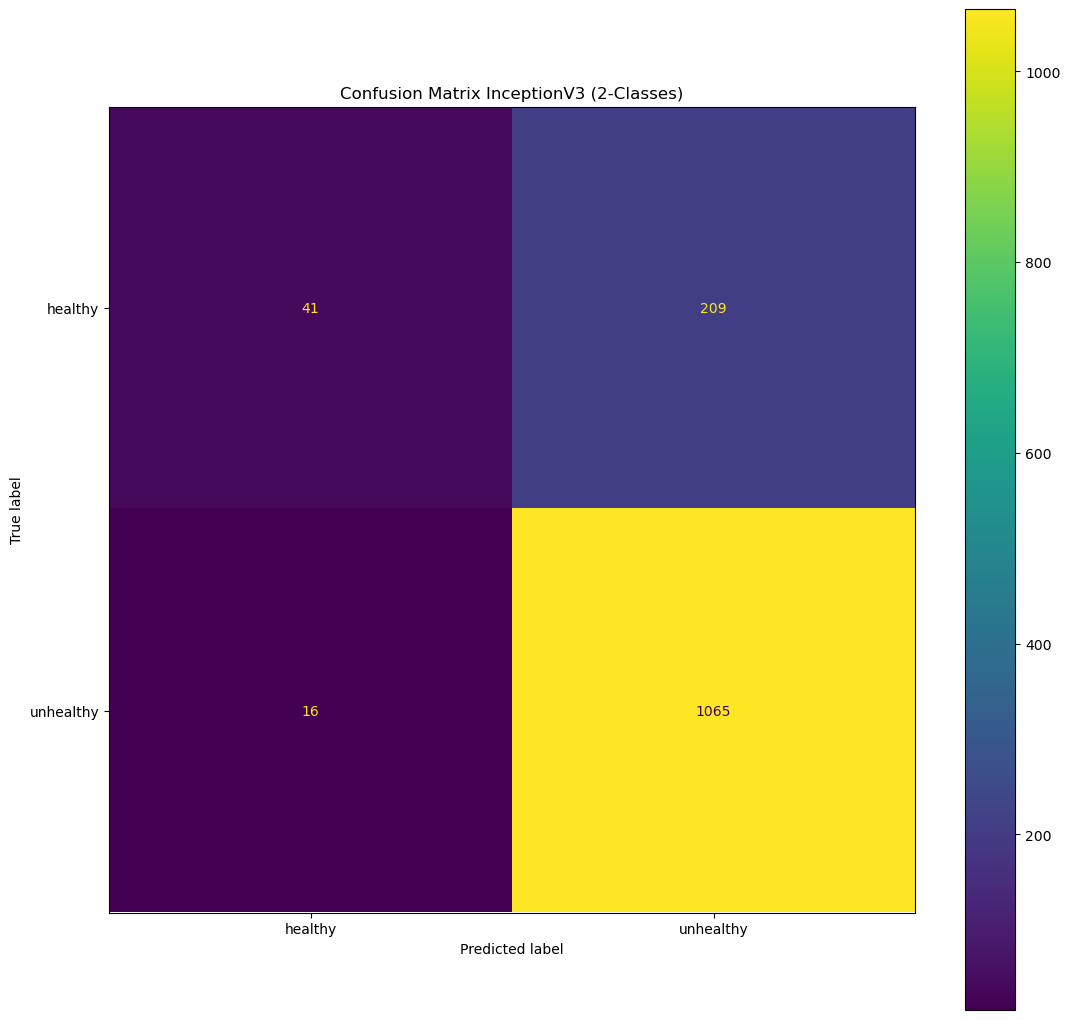

Precision Macro:0.78
Precision Micro:0.83
Recall Macro:0.57
Recall Micro:0.83
F1-Score Macro:0.59
F1-Score Micro:0.83
Fold: 3 
Epoch: 1 


/var/folders/wd/g8mvvv392p11yf16rzs6k9mr0000gn/T/ipykernel_1890/3107720099.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img, dtype=torch.float32)


Training Data: Epoch Loss: 0.323, Epoch Accuracy: 86.084, Validation Loss: 0.261,Validation accuracy: 90.452
Epoch: 2 
Training Data: Epoch Loss: 0.330, Epoch Accuracy: 85.771, Validation Loss: 0.260,Validation accuracy: 89.182
Epoch: 3 
Training Data: Epoch Loss: 0.322, Epoch Accuracy: 86.296, Validation Loss: 0.263,Validation accuracy: 90.096
Epoch: 4 
Training Data: Epoch Loss: 0.320, Epoch Accuracy: 86.364, Validation Loss: 0.248,Validation accuracy: 90.655
Epoch: 5 
Training Data: Epoch Loss: 0.322, Epoch Accuracy: 86.135, Validation Loss: 0.243,Validation accuracy: 90.350
Epoch: 6 
Training Data: Epoch Loss: 0.321, Epoch Accuracy: 86.567, Validation Loss: 0.248,Validation accuracy: 91.112
Epoch: 7 
Training Data: Epoch Loss: 0.317, Epoch Accuracy: 86.567, Validation Loss: 0.246,Validation accuracy: 91.061
Epoch: 8 
Training Data: Epoch Loss: 0.322, Epoch Accuracy: 86.101, Validation Loss: 0.244,Validation accuracy: 91.417
Epoch: 9 
Training Data: Epoch Loss: 0.320, Epoch Accuracy

Training Data: Epoch Loss: 0.307, Epoch Accuracy: 86.990, Validation Loss: 0.233,Validation accuracy: 90.909
Epoch: 71 
Training Data: Epoch Loss: 0.306, Epoch Accuracy: 87.252, Validation Loss: 0.230,Validation accuracy: 90.909
Epoch: 72 
Training Data: Epoch Loss: 0.310, Epoch Accuracy: 87.125, Validation Loss: 0.233,Validation accuracy: 90.706
Epoch: 73 
Training Data: Epoch Loss: 0.307, Epoch Accuracy: 86.888, Validation Loss: 0.232,Validation accuracy: 91.366
Epoch: 74 
Training Data: Epoch Loss: 0.310, Epoch Accuracy: 86.516, Validation Loss: 0.240,Validation accuracy: 91.315
Epoch: 75 
Training Data: Epoch Loss: 0.304, Epoch Accuracy: 86.973, Validation Loss: 0.253,Validation accuracy: 90.858
Epoch: 76 
Training Data: Epoch Loss: 0.315, Epoch Accuracy: 86.482, Validation Loss: 0.232,Validation accuracy: 91.366
Epoch: 77 
Training Data: Epoch Loss: 0.306, Epoch Accuracy: 86.888, Validation Loss: 0.230,Validation accuracy: 91.620
Epoch: 78 
Training Data: Epoch Loss: 0.309, Epoch 

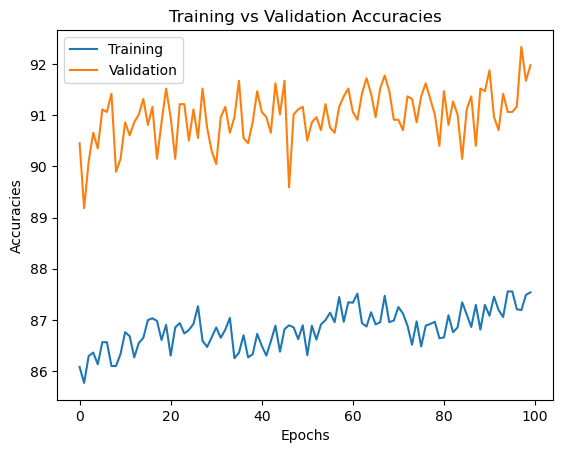

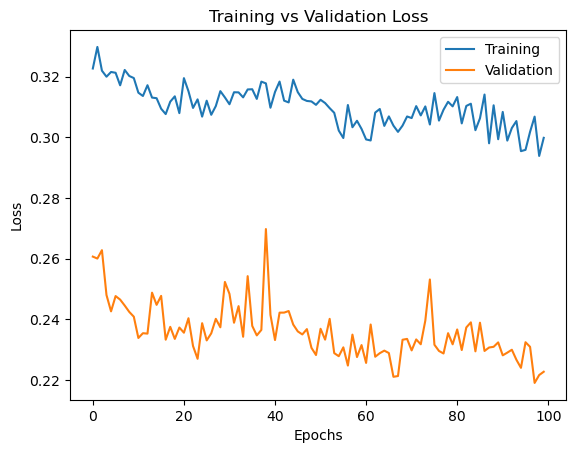

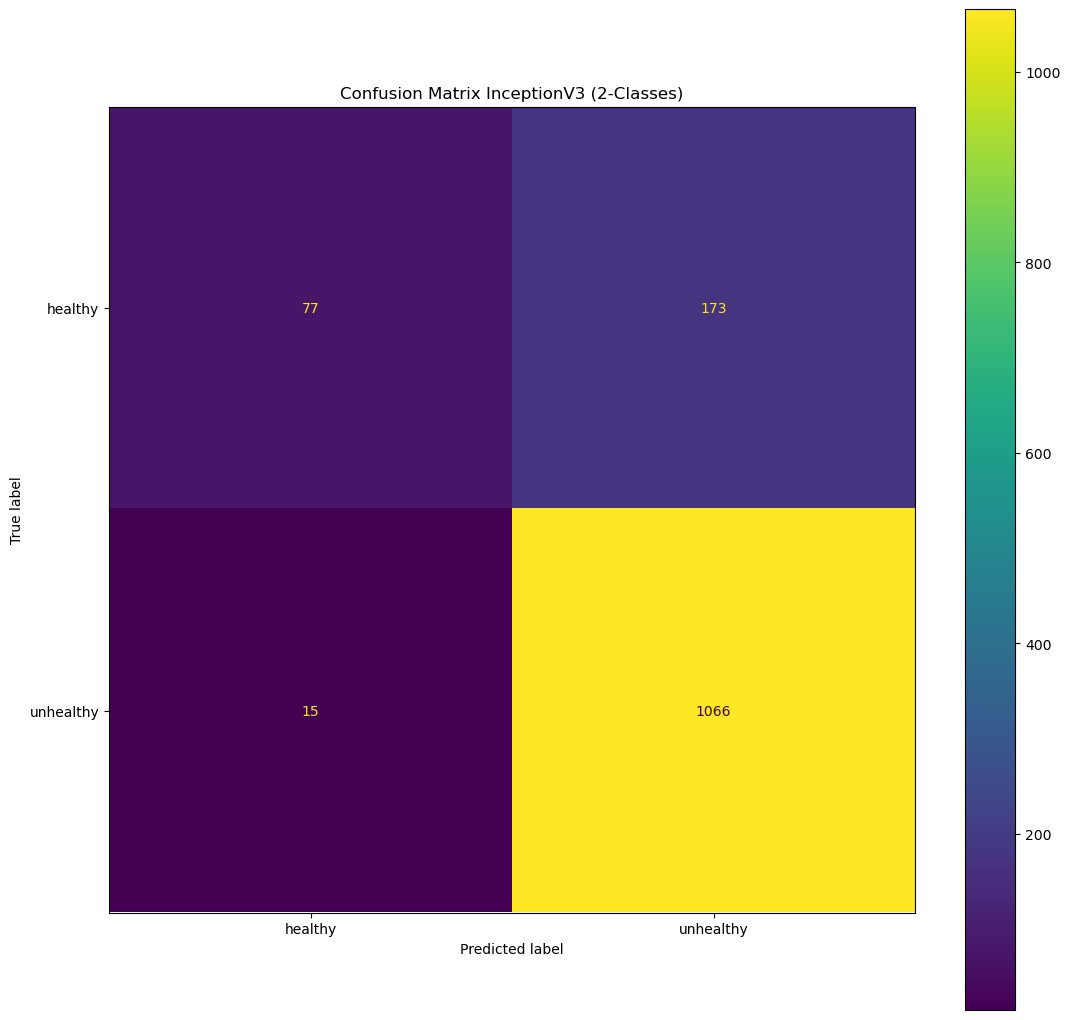

Precision Macro:0.85
Precision Micro:0.86
Recall Macro:0.65
Recall Micro:0.86
F1-Score Macro:0.68
F1-Score Micro:0.86
Fold: 4 
Epoch: 1 


/var/folders/wd/g8mvvv392p11yf16rzs6k9mr0000gn/T/ipykernel_1890/3107720099.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img, dtype=torch.float32)


Training Data: Epoch Loss: 0.301, Epoch Accuracy: 87.396, Validation Loss: 0.218,Validation accuracy: 91.925
Epoch: 2 
Training Data: Epoch Loss: 0.298, Epoch Accuracy: 87.616, Validation Loss: 0.211,Validation accuracy: 92.534
Epoch: 3 
Training Data: Epoch Loss: 0.292, Epoch Accuracy: 87.811, Validation Loss: 0.215,Validation accuracy: 92.026
Epoch: 4 
Training Data: Epoch Loss: 0.299, Epoch Accuracy: 87.235, Validation Loss: 0.217,Validation accuracy: 92.788
Epoch: 5 
Training Data: Epoch Loss: 0.299, Epoch Accuracy: 87.599, Validation Loss: 0.209,Validation accuracy: 91.722
Epoch: 6 
Training Data: Epoch Loss: 0.300, Epoch Accuracy: 87.413, Validation Loss: 0.215,Validation accuracy: 91.519
Epoch: 7 
Training Data: Epoch Loss: 0.304, Epoch Accuracy: 87.396, Validation Loss: 0.208,Validation accuracy: 92.483
Epoch: 8 
Training Data: Epoch Loss: 0.305, Epoch Accuracy: 87.176, Validation Loss: 0.218,Validation accuracy: 91.214
Epoch: 9 
Training Data: Epoch Loss: 0.305, Epoch Accuracy

Training Data: Epoch Loss: 0.303, Epoch Accuracy: 86.973, Validation Loss: 0.214,Validation accuracy: 92.687
Epoch: 71 
Training Data: Epoch Loss: 0.293, Epoch Accuracy: 87.803, Validation Loss: 0.207,Validation accuracy: 92.179
Epoch: 72 
Training Data: Epoch Loss: 0.302, Epoch Accuracy: 87.219, Validation Loss: 0.206,Validation accuracy: 92.636
Epoch: 73 
Training Data: Epoch Loss: 0.292, Epoch Accuracy: 87.836, Validation Loss: 0.226,Validation accuracy: 91.417
Epoch: 74 
Training Data: Epoch Loss: 0.297, Epoch Accuracy: 87.693, Validation Loss: 0.216,Validation accuracy: 91.976
Epoch: 75 
Training Data: Epoch Loss: 0.296, Epoch Accuracy: 87.252, Validation Loss: 0.209,Validation accuracy: 91.976
Epoch: 76 
Training Data: Epoch Loss: 0.299, Epoch Accuracy: 87.566, Validation Loss: 0.213,Validation accuracy: 92.128
Epoch: 77 
Training Data: Epoch Loss: 0.292, Epoch Accuracy: 87.506, Validation Loss: 0.206,Validation accuracy: 92.077
Epoch: 78 
Training Data: Epoch Loss: 0.292, Epoch 

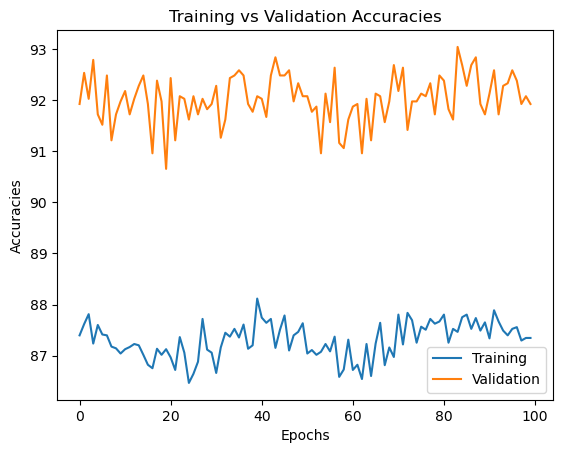

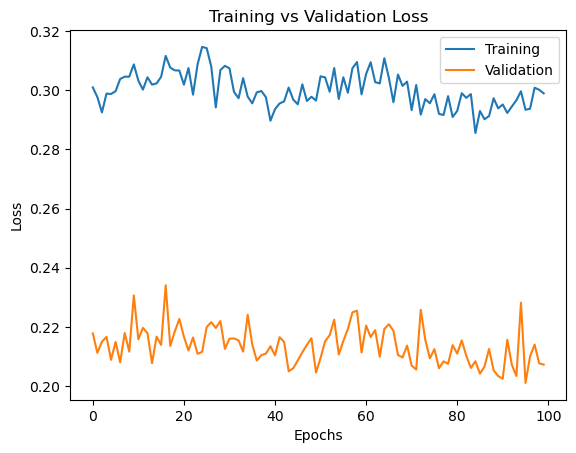

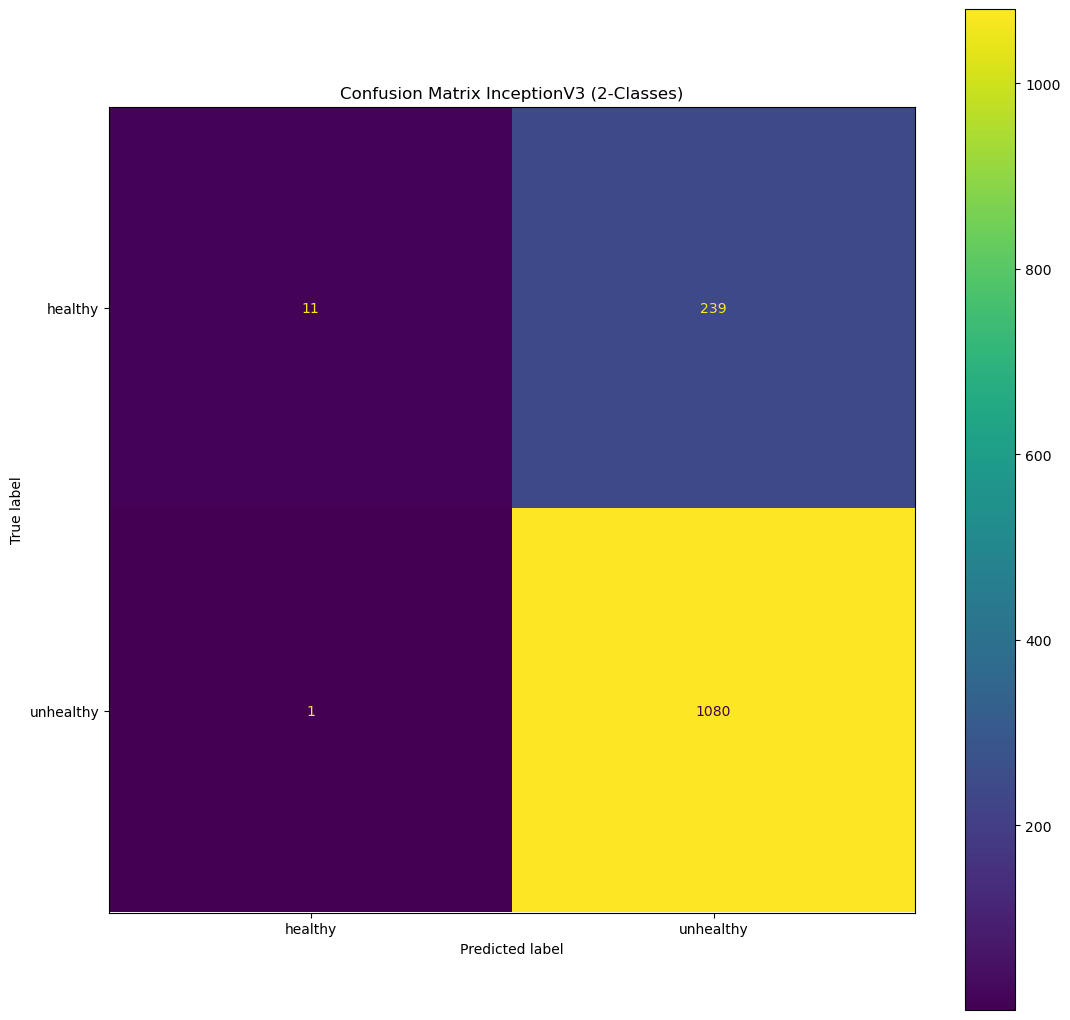

Precision Macro:0.87
Precision Micro:0.82
Recall Macro:0.52
Recall Micro:0.82
F1-Score Macro:0.49
F1-Score Micro:0.82
Fold: 5 
Epoch: 1 


/var/folders/wd/g8mvvv392p11yf16rzs6k9mr0000gn/T/ipykernel_1890/3107720099.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img, dtype=torch.float32)


Training Data: Epoch Loss: 0.299, Epoch Accuracy: 87.337, Validation Loss: 0.197,Validation accuracy: 92.483
Epoch: 2 
Training Data: Epoch Loss: 0.302, Epoch Accuracy: 86.821, Validation Loss: 0.197,Validation accuracy: 92.687
Epoch: 3 
Training Data: Epoch Loss: 0.295, Epoch Accuracy: 87.557, Validation Loss: 0.199,Validation accuracy: 92.636
Epoch: 4 
Training Data: Epoch Loss: 0.296, Epoch Accuracy: 87.159, Validation Loss: 0.208,Validation accuracy: 92.128
Epoch: 5 
Training Data: Epoch Loss: 0.303, Epoch Accuracy: 87.489, Validation Loss: 0.206,Validation accuracy: 92.941
Epoch: 6 
Training Data: Epoch Loss: 0.300, Epoch Accuracy: 87.261, Validation Loss: 0.204,Validation accuracy: 92.077
Epoch: 7 
Training Data: Epoch Loss: 0.305, Epoch Accuracy: 87.083, Validation Loss: 0.206,Validation accuracy: 93.042
Epoch: 8 
Training Data: Epoch Loss: 0.295, Epoch Accuracy: 87.312, Validation Loss: 0.210,Validation accuracy: 92.534
Epoch: 9 
Training Data: Epoch Loss: 0.301, Epoch Accuracy

Training Data: Epoch Loss: 0.294, Epoch Accuracy: 87.769, Validation Loss: 0.192,Validation accuracy: 93.042
Epoch: 71 
Training Data: Epoch Loss: 0.289, Epoch Accuracy: 88.023, Validation Loss: 0.211,Validation accuracy: 92.890
Epoch: 72 
Training Data: Epoch Loss: 0.291, Epoch Accuracy: 87.295, Validation Loss: 0.192,Validation accuracy: 93.042
Epoch: 73 
Training Data: Epoch Loss: 0.293, Epoch Accuracy: 87.659, Validation Loss: 0.202,Validation accuracy: 93.296
Epoch: 74 
Training Data: Epoch Loss: 0.291, Epoch Accuracy: 87.752, Validation Loss: 0.195,Validation accuracy: 93.398
Epoch: 75 
Training Data: Epoch Loss: 0.292, Epoch Accuracy: 87.439, Validation Loss: 0.193,Validation accuracy: 92.890
Epoch: 76 
Training Data: Epoch Loss: 0.299, Epoch Accuracy: 87.269, Validation Loss: 0.199,Validation accuracy: 92.737
Epoch: 77 
Training Data: Epoch Loss: 0.297, Epoch Accuracy: 87.464, Validation Loss: 0.208,Validation accuracy: 91.722
Epoch: 78 
Training Data: Epoch Loss: 0.296, Epoch 

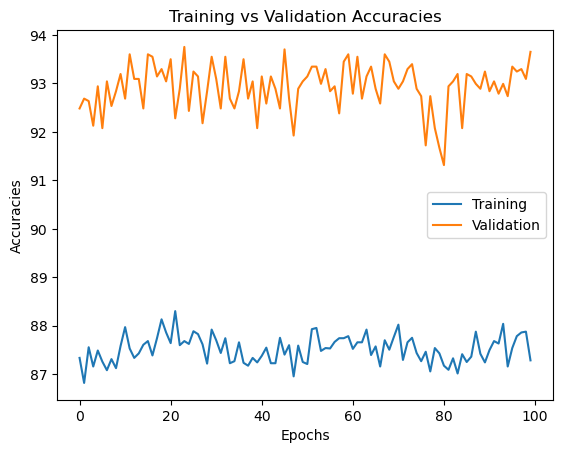

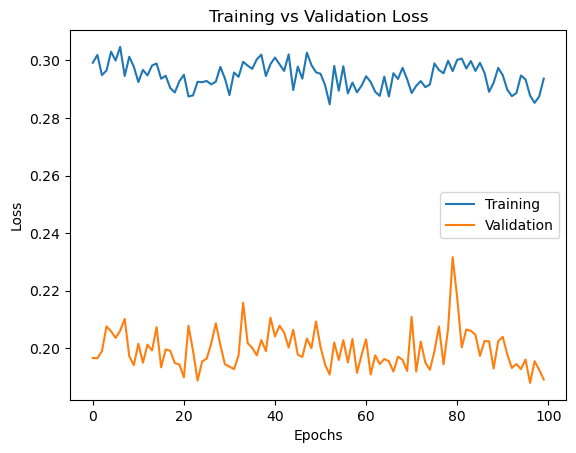

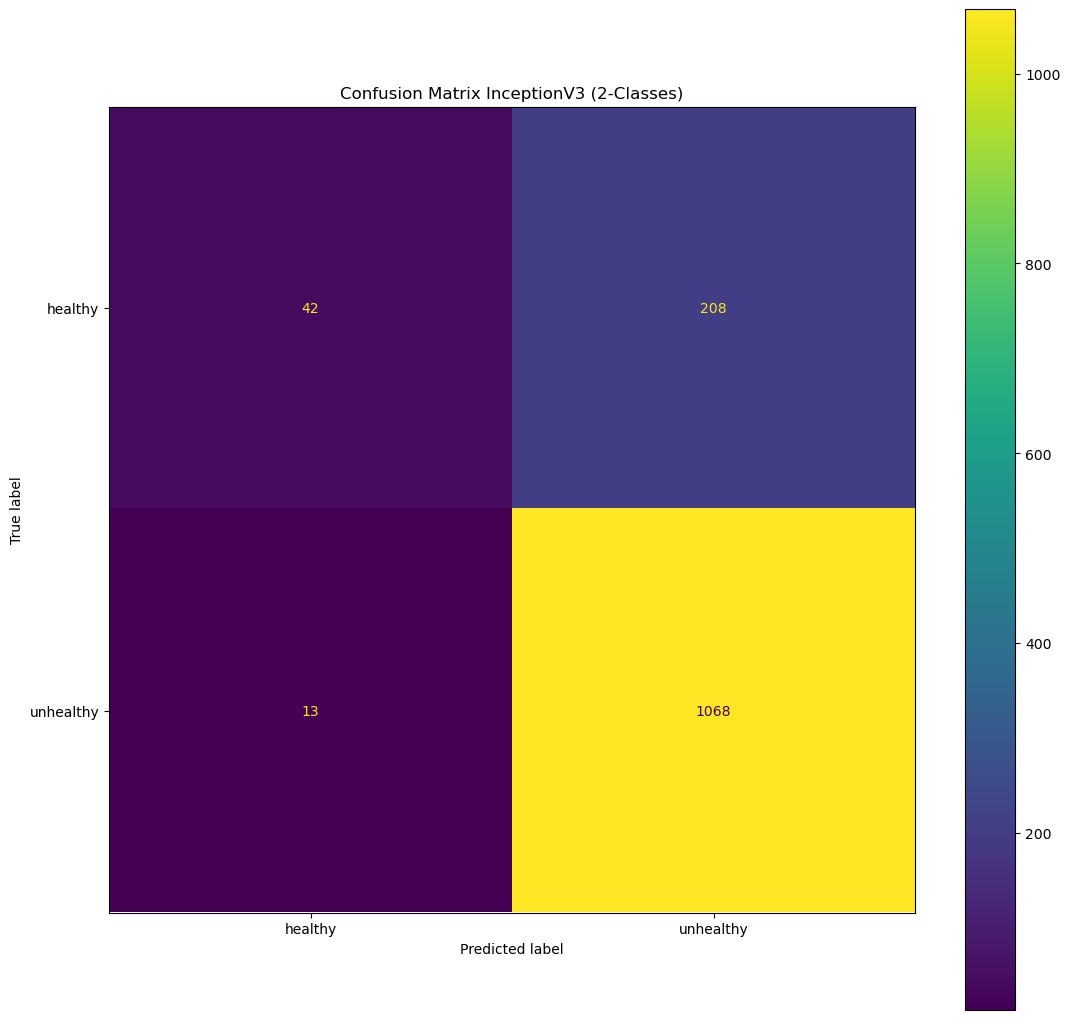

Precision Macro:0.80
Precision Micro:0.83
Recall Macro:0.58
Recall Micro:0.83
F1-Score Macro:0.59
F1-Score Micro:0.83
Fold: 6 
Epoch: 1 


/var/folders/wd/g8mvvv392p11yf16rzs6k9mr0000gn/T/ipykernel_1890/3107720099.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img, dtype=torch.float32)


Training Data: Epoch Loss: 0.290, Epoch Accuracy: 87.997, Validation Loss: 0.203,Validation accuracy: 92.331
Epoch: 2 
Training Data: Epoch Loss: 0.282, Epoch Accuracy: 88.150, Validation Loss: 0.204,Validation accuracy: 92.534
Epoch: 3 
Training Data: Epoch Loss: 0.289, Epoch Accuracy: 87.938, Validation Loss: 0.206,Validation accuracy: 91.671
Epoch: 4 
Training Data: Epoch Loss: 0.291, Epoch Accuracy: 87.549, Validation Loss: 0.202,Validation accuracy: 92.737
Epoch: 5 
Training Data: Epoch Loss: 0.284, Epoch Accuracy: 88.217, Validation Loss: 0.202,Validation accuracy: 92.382
Epoch: 6 
Training Data: Epoch Loss: 0.286, Epoch Accuracy: 87.997, Validation Loss: 0.201,Validation accuracy: 91.620
Epoch: 7 
Training Data: Epoch Loss: 0.287, Epoch Accuracy: 88.023, Validation Loss: 0.198,Validation accuracy: 91.722
Epoch: 8 
Training Data: Epoch Loss: 0.289, Epoch Accuracy: 88.167, Validation Loss: 0.200,Validation accuracy: 91.925
Epoch: 9 
Training Data: Epoch Loss: 0.280, Epoch Accuracy

Training Data: Epoch Loss: 0.290, Epoch Accuracy: 88.090, Validation Loss: 0.203,Validation accuracy: 92.077
Epoch: 71 
Training Data: Epoch Loss: 0.289, Epoch Accuracy: 87.989, Validation Loss: 0.208,Validation accuracy: 91.772
Epoch: 72 
Training Data: Epoch Loss: 0.281, Epoch Accuracy: 88.581, Validation Loss: 0.204,Validation accuracy: 92.585
Epoch: 73 
Training Data: Epoch Loss: 0.279, Epoch Accuracy: 88.133, Validation Loss: 0.208,Validation accuracy: 92.382
Epoch: 74 
Training Data: Epoch Loss: 0.289, Epoch Accuracy: 88.167, Validation Loss: 0.201,Validation accuracy: 92.433
Epoch: 75 
Training Data: Epoch Loss: 0.293, Epoch Accuracy: 87.820, Validation Loss: 0.198,Validation accuracy: 92.128
Epoch: 76 
Training Data: Epoch Loss: 0.282, Epoch Accuracy: 88.192, Validation Loss: 0.205,Validation accuracy: 91.417
Epoch: 77 
Training Data: Epoch Loss: 0.288, Epoch Accuracy: 87.786, Validation Loss: 0.200,Validation accuracy: 92.280
Epoch: 78 
Training Data: Epoch Loss: 0.286, Epoch 

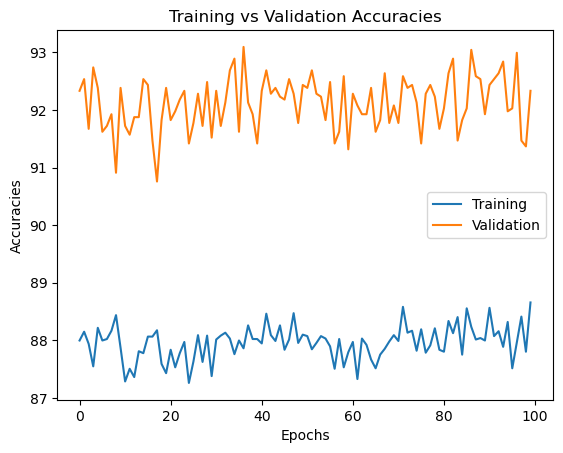

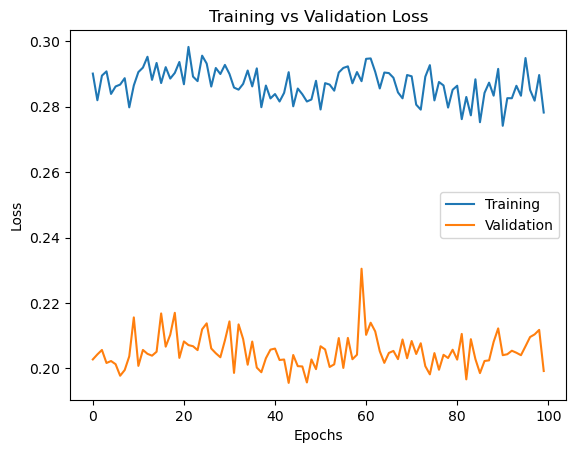

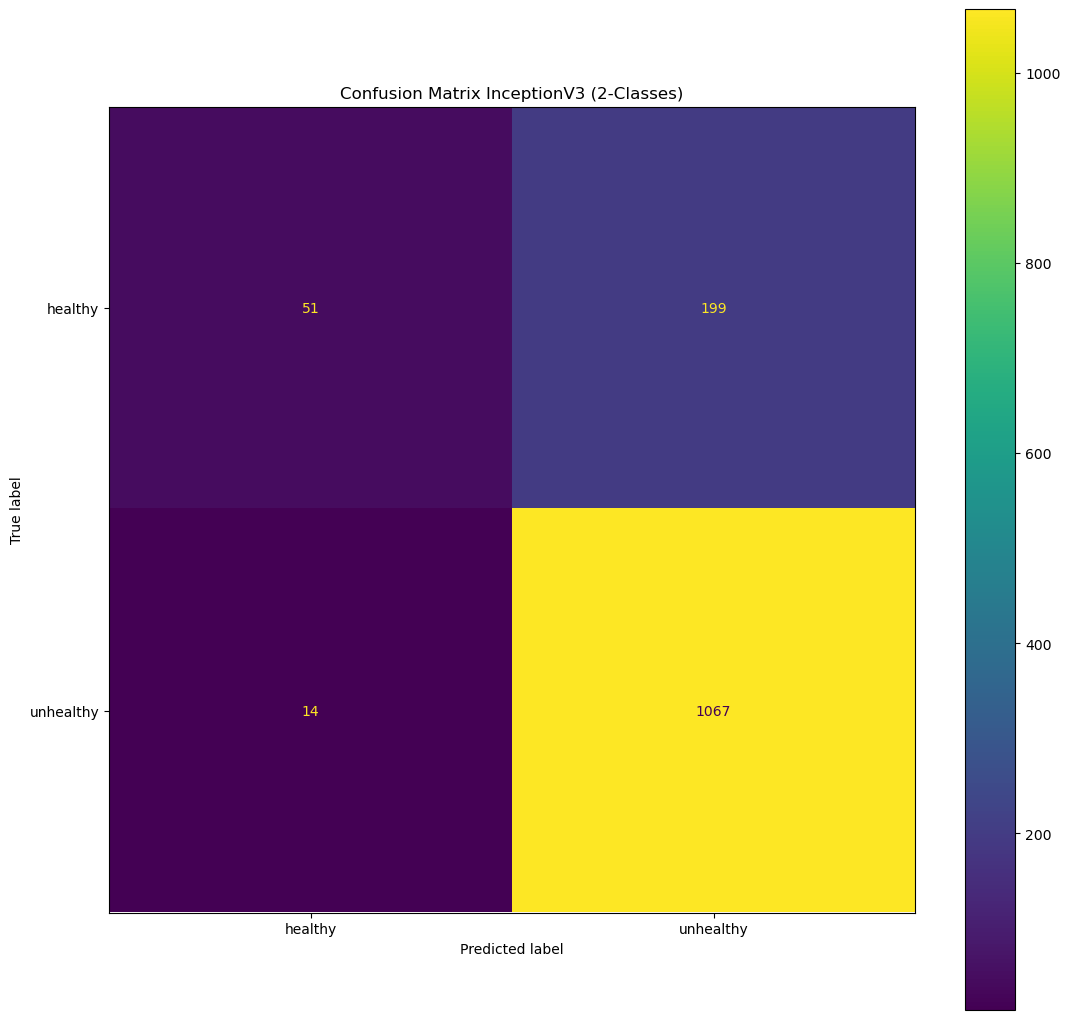

Precision Macro:0.81
Precision Micro:0.84
Recall Macro:0.60
Recall Micro:0.84
F1-Score Macro:0.62
F1-Score Micro:0.84
Fold: 7 
Epoch: 1 


/var/folders/wd/g8mvvv392p11yf16rzs6k9mr0000gn/T/ipykernel_1890/3107720099.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img, dtype=torch.float32)


Training Data: Epoch Loss: 0.293, Epoch Accuracy: 87.853, Validation Loss: 0.189,Validation accuracy: 92.280
Epoch: 2 
Training Data: Epoch Loss: 0.298, Epoch Accuracy: 87.481, Validation Loss: 0.182,Validation accuracy: 92.991
Epoch: 3 
Training Data: Epoch Loss: 0.291, Epoch Accuracy: 87.947, Validation Loss: 0.185,Validation accuracy: 92.788
Epoch: 4 
Training Data: Epoch Loss: 0.287, Epoch Accuracy: 87.684, Validation Loss: 0.181,Validation accuracy: 93.652
Epoch: 5 
Training Data: Epoch Loss: 0.288, Epoch Accuracy: 87.667, Validation Loss: 0.192,Validation accuracy: 93.347
Epoch: 6 
Training Data: Epoch Loss: 0.295, Epoch Accuracy: 87.642, Validation Loss: 0.179,Validation accuracy: 92.941
Epoch: 7 
Training Data: Epoch Loss: 0.290, Epoch Accuracy: 87.752, Validation Loss: 0.193,Validation accuracy: 93.195
Epoch: 8 
Training Data: Epoch Loss: 0.280, Epoch Accuracy: 87.921, Validation Loss: 0.185,Validation accuracy: 93.245
Epoch: 9 
Training Data: Epoch Loss: 0.287, Epoch Accuracy

Training Data: Epoch Loss: 0.283, Epoch Accuracy: 88.463, Validation Loss: 0.182,Validation accuracy: 93.652
Epoch: 71 
Training Data: Epoch Loss: 0.289, Epoch Accuracy: 87.760, Validation Loss: 0.186,Validation accuracy: 92.839
Epoch: 72 
Training Data: Epoch Loss: 0.290, Epoch Accuracy: 87.904, Validation Loss: 0.179,Validation accuracy: 93.448
Epoch: 73 
Training Data: Epoch Loss: 0.283, Epoch Accuracy: 88.564, Validation Loss: 0.181,Validation accuracy: 93.144
Epoch: 74 
Training Data: Epoch Loss: 0.289, Epoch Accuracy: 87.464, Validation Loss: 0.188,Validation accuracy: 93.499
Epoch: 75 
Training Data: Epoch Loss: 0.287, Epoch Accuracy: 87.625, Validation Loss: 0.181,Validation accuracy: 93.195
Epoch: 76 
Training Data: Epoch Loss: 0.287, Epoch Accuracy: 88.040, Validation Loss: 0.190,Validation accuracy: 92.991
Epoch: 77 
Training Data: Epoch Loss: 0.283, Epoch Accuracy: 88.082, Validation Loss: 0.204,Validation accuracy: 92.179
Epoch: 78 
Training Data: Epoch Loss: 0.281, Epoch 

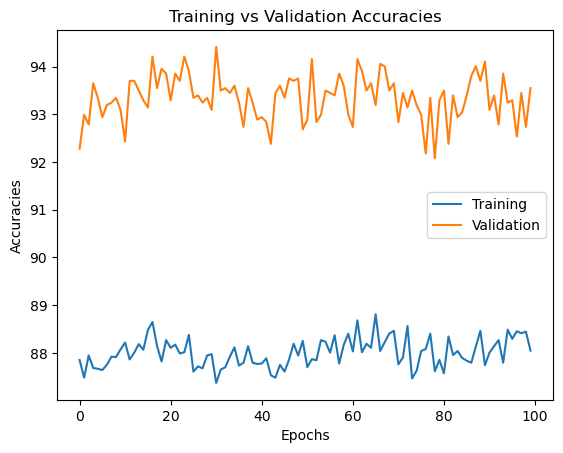

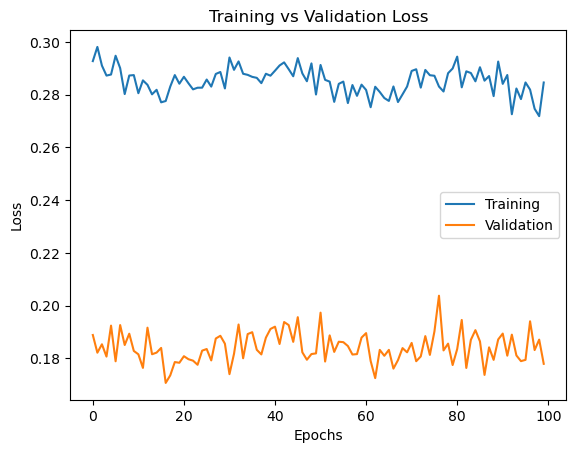

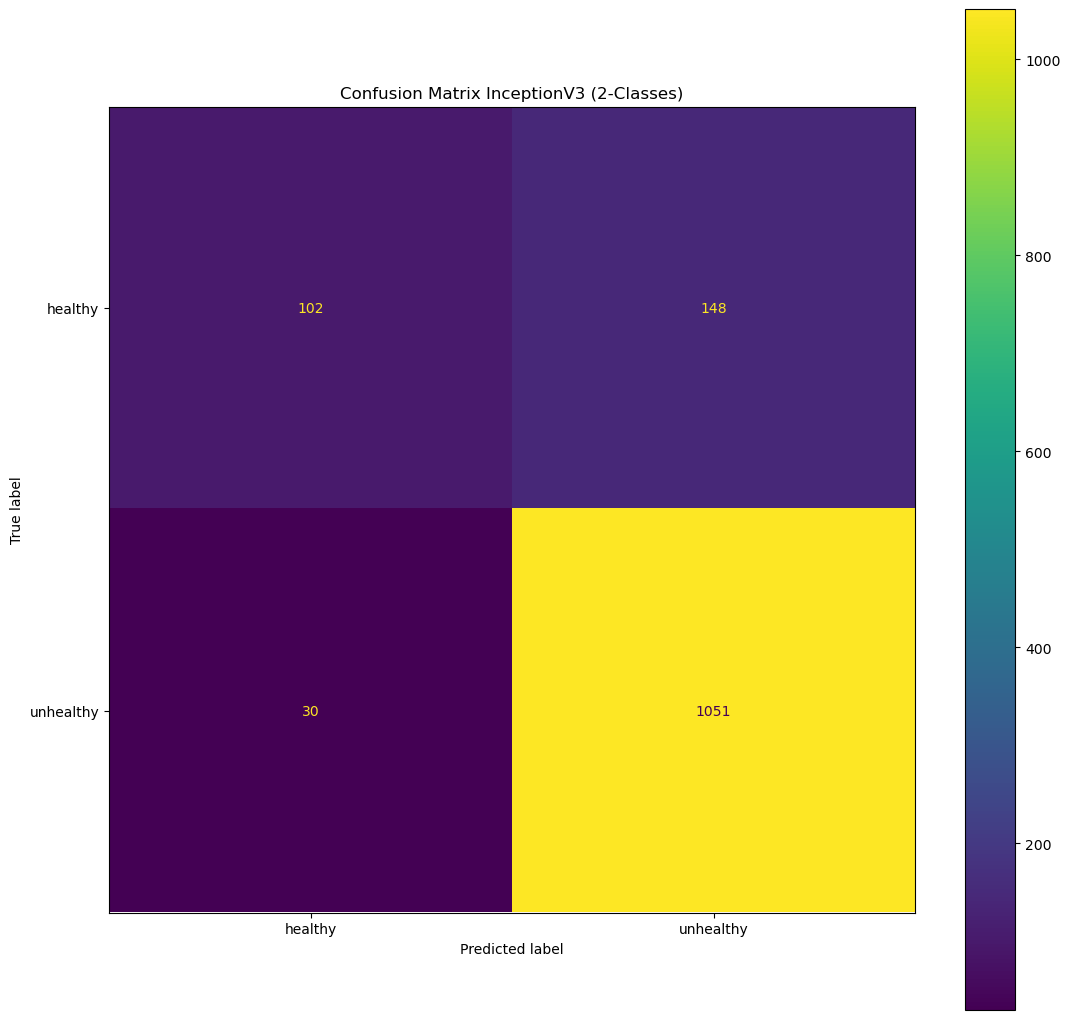

Precision Macro:0.82
Precision Micro:0.87
Recall Macro:0.69
Recall Micro:0.87
F1-Score Macro:0.73
F1-Score Micro:0.87


In [24]:
for fold, (train_indexes, val_indexes) in enumerate(kfold.split(data_t, labels_t)):
    print("Fold: %d "%(fold+1))
    t1 = time.time()
    
    train_data, train_labels = data_t[train_indexes], labels_t[train_indexes]
    val_data, val_labels = data_t[val_indexes], labels_t[val_indexes]

    train_dataset = ImageDataset(train_data, train_labels)
    val_dataset = ImageDataset(val_data, val_labels)

    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=32)

    n_epochs = 100
    epoch_count = 0
    Accuracies = [] 
    valAccuracies = []
    valLoss = []
    trainLoss = []
    validation_accuracy = 0
    for epoch in range(n_epochs):
      print("Epoch: %d "%(epoch+1))
      model.train()
      running_loss=0.0
      running_correct=0.0
      val_loss=0.0
      total=0
      for i,data in enumerate(train_dataloader):
        images,labels=data
        images=images.to(device)
        labels=labels.to(device)
        total+=labels.size(0)
        optimizer.zero_grad()
        outputs=model(images)
        _,predicted=torch.max(outputs.data,1)
        loss=loss_fn(outputs,labels)
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
        running_correct+=(labels==predicted).sum().item()
        traning_accuracy=(running_correct/total)*100
    
      validation_accuracy=0
      model.eval()
      with torch.no_grad():
        val_correct=0
        val_total=0
        val_loss=0
        for data in val_dataloader:
            images,val_labels=data[0].to(device), data[1].to(device)
            images = images.to(device)
            val_labels = val_labels.to(device)
            outputs=model(images)
            loss_val=loss_fn(outputs,val_labels)
            val_loss+= loss_val.item()
            _,predicted=torch.max(outputs.data,1)
            val_correct+=(predicted == val_labels).sum().item()
            val_total+=val_labels.size(0)
        validation_accuracy = (val_correct / val_total) *100
    
      scheduler.step()
      epoch_loss=running_loss/len(train_dataloader)
      val_loss=val_loss/len(val_dataloader)
      epoch_accuracy=100.00* running_correct/total
      Accuracies.append(epoch_accuracy)
      valAccuracies.append(validation_accuracy)
      trainLoss.append(epoch_loss)
      valLoss.append(val_loss)

      print("Training Data: Epoch Loss: %.3f, Epoch Accuracy: %.3f, Validation Loss: %.3f,Validation accuracy: %.3f"%(epoch_loss,epoch_accuracy,val_loss,validation_accuracy))

    test_accuracy=evaluate_model(model,test_loader)

    print("---Training finished in {} seconds---".format(time.time()-t1))
    torch.save(model.state_dict(), "2-Class-Inceptionv3-"+str(fold)+"_"+str(epoch_count)+"-epoch.pt")

    dict = {'Training': Accuracies, 'Validation': valAccuracies} 
    dictLoss = {'Training': trainLoss,'Validation': valLoss}
    df = pd.DataFrame(dict)
    df2 = pd.DataFrame(dictLoss)
#     df.to_csv("/content/Accuracies"+str(fold)+"_"+str(epoch)+".csv")
#     df2.to_csv("/content/Loss"+str(fold)+"_"+str(epoch)+".csv")

    fold_train_accuracy.append(mean(Accuracies))
    fold_train_loss.append(mean(trainLoss))
    fold_val_accuracy.append(mean(valAccuracies))
    fold_val_loss.append(mean(valLoss))
    fold_test_accuracy.append(test_accuracy)

    plt.plot(range(n_epochs),Accuracies, label="Training")
    plt.plot(range(n_epochs),valAccuracies, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracies")
    plt.title("Training vs Validation Accuracies")
    plt.legend()
    plt.show()

    plt.plot(range(n_epochs),trainLoss, label="Training")
    plt.plot(range(n_epochs),valLoss, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.show()

    y_pred = []
    y_true = []

    for image_data in test_loader:
        images,targets = image_data[0].to(device), image_data[1].to(device)
        output = model(images) 
        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) 
        targets = targets.data.cpu().numpy()
        y_true.extend(targets)

    
    confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred),display_labels=classes)
    fig,ax = plt.subplots()
    fig.set_size_inches(13,13)
    plt.title("Confusion Matrix InceptionV3 (2-Classes)")
    disp.plot(ax=ax)
    plt.show()  

    fold_precision_score.append(precision_score(y_true, y_pred, average='macro'))
    fold_recall_score.append(recall_score(y_true,y_pred,average='macro'))
    fold_f1_score.append(f1_score(y_true,y_pred,average='macro'))

    print("Precision Macro:{:.2f}".format(precision_score(y_true, y_pred, average='macro')))
    print("Precision Micro:{:.2f}".format(precision_score(y_true,y_pred,average='micro')))
    print("Recall Macro:{:.2f}".format(recall_score(y_true,y_pred,average='macro')))
    print("Recall Micro:{:.2f}".format(recall_score(y_true,y_pred,average='micro')))
    print("F1-Score Macro:{:.2f}".format(f1_score(y_true,y_pred,average='macro')))
    print("F1-Score Micro:{:.2f}".format(f1_score(y_true,y_pred,average='micro')))


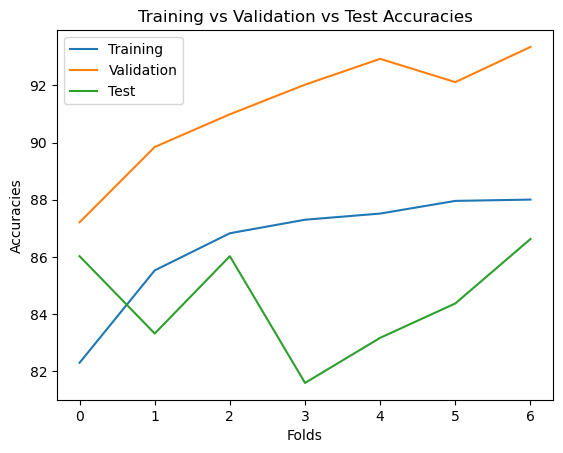

In [25]:
plt.plot(range(7),fold_train_accuracy, label="Training")
plt.plot(range(7),fold_val_accuracy, label="Validation")
plt.plot(range(7),fold_test_accuracy, label="Test")
plt.xlabel("Folds")
plt.ylabel("Accuracies")
plt.title("Training vs Validation vs Test Accuracies")
plt.legend()
plt.show()

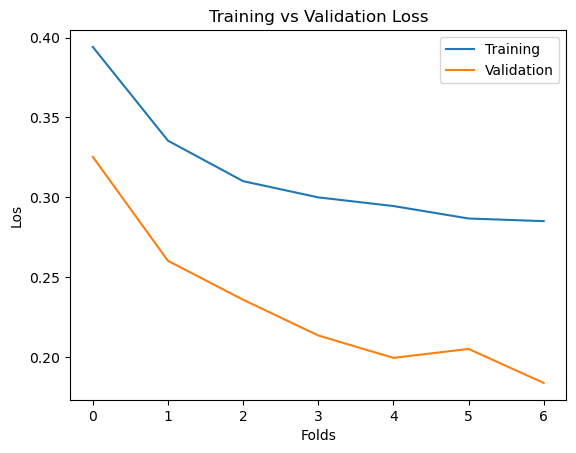

In [26]:
plt.plot(range(7),fold_train_loss, label="Training")
plt.plot(range(7),fold_val_loss, label="Validation")
plt.xlabel("Folds")
plt.ylabel("Los")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

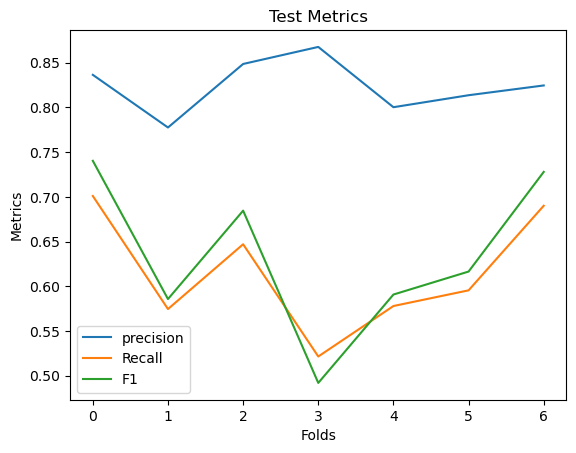

In [27]:
plt.plot(range(7),fold_precision_score, label="precision")
plt.plot(range(7),fold_recall_score, label="Recall")
plt.plot(range(7),fold_f1_score, label="F1")
plt.xlabel("Folds")
plt.ylabel("Metrics")
plt.title("Test Metrics")
plt.legend()
plt.show()